# Classification Model

- This notebook is a continuation of the "SQL_EDA" notebook
    - The cleaned dataset from the "SQL_Data_Cleaning" notebook will be used here.
- This notebook is outlined by the following tasks:
    - Prepare dataset for modeling
        - consolidate data by race
        - convert features to desired data types
        - train-test split
    - Building baseline models and compare performance
        - Use confusion matrices and ROC curves
    - Perform grid search on best-performing models
    - Run finalized model on test set and determine ideal classification threshold

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from tqdm.notebook import tqdm

from collections import defaultdict
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import fbeta_score, make_scorer

# Load in Cleaned Dataset: `demo_killings_df`

In [2]:
with open('Data/sql_demo_killings_df.pkl','rb') as read_file:
    demo_killings_df = pickle.load(read_file)

In [3]:
demo_killings_df

city state city_type      region  year      month day_of_week  \
0            Oshkosh    WI      City     Midwest  2017  July        Monday      
1               Napa    CA      City  West Coast  2015  March       Friday      
2               Napa    CA      City  West Coast  2017  April       Tuesday     
3               Napa    CA      City  West Coast  2017  March       Monday      
4           Fairmont    WV      City       South  2016  December    Sunday      
...              ...   ...       ...         ...   ...        ...         ...   
2287        Tiverton    RI       Cdp   Northeast  2016  June        Monday      
2288  Silver Springs    NV       Cdp    Mountain  2016  February    Thursday    
2289       Palo Alto    CA      City  West Coast  2015  December    Friday      
2290          Malone    NY   Village   Northeast  2015  June        Friday      
2291      Mount Hope    WV      City       South  2015  December    Monday      

     manner_of_death         armed   age  ...         flee body_camera  \
0               shot       vehicle  28.0  ...          Car        True   
1               shot           gun  41.0  ...        Other       False   
2               shot           gun  65.0  ...          Car       False   
3               shot  sharp object  23.0  ...  Not fleeing       False   
4               shot       vehicle  39.0  ...  Not fleeing       False   
...              ...           ...   ...  ...          ...         ...   
2287            shot           gun  80.0  ...          Car       False   
2288            shot           gun  19.0  ...  Not fleeing        True   
2289            shot  sharp object  31.0  ...  Not fleeing       False   
2290            shot           gun  49.0  ...        Other       False   
2291            shot           gun  33.0  ...  Not fleeing       False   

      poverty_rate percent_completed_hs share_white  share_black  \
0             17.9                 89.3        90.5          3.1   
1              9.5                 80.9        75.1          0.6   
2              9.5                 80.9        75.1          0.6   
3              9.5                 80.9        75.1          0.6   
4             24.9                 88.1        88.9          7.5   
...            ...                  ...         ...          ...   
2287           6.8                 89.4        95.7          1.2   
2288          22.8                 81.4        89.0          0.3   
2289           5.4                 97.4        64.2          1.9   
2290          31.1                 81.2        96.0          0.6   
2291          42.3                 88.1        77.0         18.0   

      share_native_american  share_asian  share_hispanic  median_income  
0                       0.8          3.2             2.7        42650.0  
1                       0.8          2.3            37.6        68038.0  
2                       0.8          2.3            37.6        68038.0  
3                       0.8          2.3            37.6        68038.0  
4                       0.2          0.6             1.4        36086.0  
...                     ...          ...             ...            ...  
2287                    0.1          1.0             1.7        69054.0  
2288                    2.0          0.9             7.4        33780.0  
2289                    0.2         27.1             6.2       136519.0  
2290                    1.1          0.8             1.6        36667.0  
2291                    0.5          0.4             1.6        21218.0  

[2292 rows x 24 columns]

# Prepare Dataset for Modeling

## Consolidate to specific races (W, B, H)

- Data is well-balanced (48.6%/51.4% split by class)

In [4]:
class_killings_df = demo_killings_df.loc[demo_killings_df['race'].isin(['W', 'B', 'H'])].reset_index(drop=True)


In [5]:
class_killings_df.race.value_counts()

W    1041
B     578
H     405
Name: race, dtype: int64

## Convert Features to Desired Data Types

- numerical
    - year
    - age
    - poverty_rate
    - percent_completed_hs
    - share_white
    - share_black
    - share_native_american
    - share_asian
    - share_hispanic
    - median_income
- boolean
    - gender
    - top 30 city
    - signs_of_mental_illness
    - body_camera
    - day_of_week
    - manner_of_death
    - armed
    - threat_level
    - flee
- categorical
    - month
    - region

### Boolean

In [6]:
# Race (target variable)

class_killings_df.race = [0 if race == 'W' else 1 for race in class_killings_df.race.values]

In [7]:
# Gender

class_killings_df.gender = [1 if gen == 'M' else 0 for gen in class_killings_df.gender.values]

In [8]:
# Manner of Death

class_killings_df.manner_of_death = [1 if gun == 'shot' else 0 for gun in class_killings_df.manner_of_death.values]

In [9]:
# Day of Week

class_killings_df.day_of_week = [1 if day == 'Thursday' else 0 for day in class_killings_df.day_of_week.values]

In [10]:
# Top 30 City

top_30_city = [1 if city in class_killings_df.city.value_counts().index[:30] else 0 for city in class_killings_df.city.values]

class_killings_df.insert(7, 'top_30_city', top_30_city)

In [11]:
# City Type

class_killings_df.city_type = [1 if city == 'City' else 0 for city in class_killings_df.city_type.values]

In [12]:
# # Region

# coasts = ['West Coast', 'Northeast']

# class_killings_df.region = [1 if region in coasts else 0 for region in class_killings_df.region.values]

In [13]:
# Armed

class_killings_df.armed = [0 if arm == 'unarmed' else 1 for arm in class_killings_df.armed.values]

In [14]:
# Flee

class_killings_df.flee = [0 if flee == 'Foot' else 1 for flee in class_killings_df.flee.values]

In [15]:
# Threat Level

class_killings_df.threat_level = [0 if threat == 'undetermined' else 1 for threat in class_killings_df.threat_level.values]

In [16]:
# Signs of Mental Illness, Body Camera

for column in ['signs_of_mental_illness', 'body_camera']:
    class_killings_df[column] = [1 if i == True else 0 for i in class_killings_df[column].values]

### Categorical

In [17]:
class_killings_df.columns

Index(['city', 'state', 'city_type', 'region', 'year', 'month', 'day_of_week',
       'top_30_city', 'manner_of_death', 'armed', 'age', 'gender', 'race',
       'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera',
       'poverty_rate', 'percent_completed_hs', 'share_white', 'share_black',
       'share_native_american', 'share_asian', 'share_hispanic',
       'median_income'],
      dtype='object')

In [18]:
model_killings_df = class_killings_df[['year', 'month', 'day_of_week', 'top_30_city', 'city_type', 'region',
                                       'age', 'gender', 'manner_of_death', 'armed', 'signs_of_mental_illness', 
                                       'threat_level', 'flee', 'body_camera', 'poverty_rate', 'percent_completed_hs', 
                                       'share_white', 'share_black', 'share_native_american', 'share_asian', 
                                       'share_hispanic', 'median_income']]

In [19]:
# one hot encoding
model_killings_df = pd.get_dummies(model_killings_df, drop_first=True)

## Train-Test Split

In [20]:
# X = model_killings_df
# y = class_killings_df.race

In [21]:
X = model_killings_df.to_numpy()
y = class_killings_df.race.to_numpy()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Standardization

In [23]:
# std = StandardScaler()
# std.fit(X_train.values)

# X_tr_scaled = std.transform(X_train.values)
# X_te_scaled = std.transform(X_test.values)

# X_tr = pd.DataFrame(X_tr_scaled, index = X_train.index, columns = X_train.columns)
# X_te = pd.DataFrame(X_te_scaled, index = X_test.index, columns = X_test.columns)

# Modeling

- Different model types:
    - Logistic Regression
    - K-nearest Neighbors
    - Decision Tree
    - Random Forest
    - AdaBoost
    - Gradient Boost
    - XGBoost
- Perform cross-validation when fitting models
- Use SMOTE to account for slight class imbalance
- Performance metrics to be evaluated:
    - accuracy (how often does the model guess correctly?)
    - precision (when the victims are POC, how often does the model guess correctly?)
    - recall (how many POC shootings does the model identify?)
    - F1 score (harmonic mean of precision and recall)

## Baseline Models

In [24]:
class_results_dict = defaultdict(list)

In [25]:
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [26]:
model_dict = {'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),    \
              'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors = 10),    \
#               'Naive Bayes': MultinomialNB(),    \
#               'LinearSVM': SGDClassifier(random_state=42),    \
#               'Non-linear SVM': SVC(gamma="scale"),    \
#               'Neural Network': MLPClassifier(),    \
              'Decision Tree': DecisionTreeClassifier(max_depth=6, random_state=42),    \
              'Random Forest': RandomForestClassifier(n_estimators = 1000, max_depth=6, random_state=42),    \
              'AdaBoost': AdaBoostClassifier(n_estimators = 1000, random_state=42),    \
              'Gradient Boost': GradientBoostingClassifier(n_estimators = 1000, max_depth=6, random_state=42),
              'XGBoost': XGBClassifier(n_estimators = 1000, max_depth=6, random_state=42)
             }

In [27]:
for mod_name, model in tqdm(model_dict.items()):
    
    print(mod_name)
    cv = 1
    
    for train_ind, val_ind in kf.split(X_train, y_train):
        X_train_ind, y_train_ind = X_train[train_ind], y_train[train_ind]
        X_smote_train, y_smote_train = SMOTE(random_state=42).fit_sample(X_train_ind, y_train_ind)
        
        X_val, y_val = X_train[val_ind], y_train[val_ind]
        
        model.fit(X_smote_train, y_smote_train);
        y_pred = model.predict(X_val)

        accuracy = round(100*accuracy_score(y_val, y_pred),3)
        precision = round(100*precision_score(y_val, y_pred),3)
        recall = round(100*recall_score(y_val, y_pred),3)
        f1 = round(2 * (precision * recall) / (precision + recall),3)

        class_results_dict['Model_Name'].append(mod_name + ' ' + str(cv))
        class_results_dict['Accuracy'].append(accuracy)
        class_results_dict[('Precision')].append(precision)
        class_results_dict[('Recall')].append(recall)
        class_results_dict[('F1-score')].append(f1)
        
        cv += 1

class_results_full = pd.DataFrame(class_results_dict)
class_results_full.Model_Name = class_results_full.Model_Name.str.strip('12345')
class_results_df = class_results_full.groupby(['Model_Name']).mean()

Logistic Regression
K-Nearest Neighbors
Decision Tree
Random Forest
AdaBoost
Gradient Boost
XGBoost



In [28]:
class_results_df.sort_values(by='Accuracy', ascending=False).reset_index()

Model_Name  Accuracy  Precision   Recall  F1-score
0        Random Forest    74.9854    73.6532  75.7034   74.6142
1  Logistic Regression    74.6134    73.4962  74.9374   74.1658
2       Gradient Boost    72.3922    71.8226  71.1288   71.4222
3              XGBoost    71.6504    71.0462  70.6130   70.7804
4        Decision Tree    71.5854    70.4206  71.5102   70.8966
5             AdaBoost    70.1688    69.1838  69.5984   69.3842
6  K-Nearest Neighbors    59.6670    59.5860  52.3010   55.6708

## Further Evaluation of Best Baseline Models

- How do the best-performing models compare using confusion matrices and ROC curves?
    - **Logistic Regression**
    - **Random Forest**
    - **Decision Tree**

In [29]:
# Logistic Regression

logit = LogisticRegression(max_iter=1000)

In [30]:
logit.fit(X_smote_train, y_smote_train)
y_pred_logit = logit.predict(X_val)

In [31]:
# Random Forest

rf = RandomForestClassifier(n_estimators = 1000, max_depth=6, random_state=42)

In [32]:
rf.fit(X_smote_train, y_smote_train)
y_pred_rf = rf.predict(X_val)

In [33]:
# Decision Tree

dec = DecisionTreeClassifier(max_depth=6, random_state=42)

In [34]:
dec.fit(X_smote_train, y_smote_train)
y_pred_dec = dec.predict(X_val)

---

In [35]:
# Confusion Matrix Function

def conf_matrix(actual, predicted, model_name):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_white', 'predicted_poc'], 
                yticklabels=['actual_white', 'actual_poc'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    bottom, top = ax.get_ylim()
    ax.set_title(model_name + ' Confusion Matrix')
    ax.set_ylim(bottom, top)
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    return

In [36]:
# ROC Curve Function

def roc_curve_generator(X_test, y_test, model_name, model_variable):

    roc_curve_dict = defaultdict(list)
    
    fpr, tpr, thresholds = roc_curve(y_test, model_variable.predict_proba(X_test)[:,1])
    roc_curve_dict[model_name] = pd.DataFrame(list(zip(fpr, tpr, thresholds)),    \
                                              columns=['False Positive Rate','True Positive Rate', 'Threshhold'])
    
    # Plot roc_curve
    
#     fig1 = plt.figure(figsize=[9,9], dpi=100)

#     plt.plot(roc_curve_dict[model_name]['False Positive Rate'].values,    \
#              roc_curve_dict[model_name]['True Positive Rate'].values,    \
#              lw=2, label=model_name)

#     plt.plot([0,1],[0,1],c='violet',ls='--')
#     plt.xlim([-0.05,1.05])
#     plt.ylim([-0.05,1.05])

#     plt.xlabel('False positive rate', fontsize=15)
#     plt.ylabel('True positive rate', fontsize=15)
#     plt.xticks(fontsize=15)
#     plt.yticks(fontsize=15)
#     plt.title('ROC Curve', fontsize=15);
#     plt.legend(fontsize=10)
    
    return roc_curve_dict

In [37]:
# Precision-Recall Curve Function

def prec_rec_curve_generator(X_test, y_test, model_name, model_variable):

    prec_rec_curve_dict = defaultdict(list)
    
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, model_variable.decision_function(X_test))
    prec_rec_curve_dict[model_name] = pd.DataFrame(list(zip(precision_curve, recall_curve, threshold_curve)),    \
                                                   columns=['precision','recall','threshold'])

    # Plot precision_recall_curve
    
    fig2 = plt.figure(figsize=[9,9], dpi=100)

    plt.plot(prec_rec_curve_dict[model_name]['recall'].values,    \
             prec_rec_curve_dict[model_name]['precision'].values,    \
             lw=2, label=model_name)

    plt.plot([1,0],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Precision-Recall Curve', fontsize=15);
    plt.legend(fontsize=10)
    
    return prec_rec_curve_dict

#### Confusion Matrix

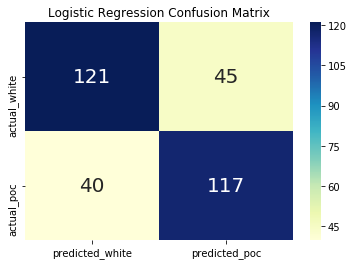

In [38]:
conf_matrix(y_val, y_pred_logit, 'Logistic Regression')

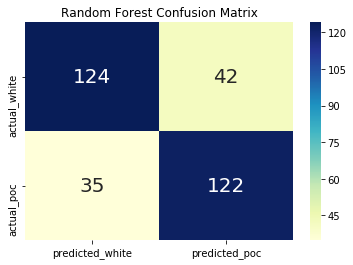

In [39]:
conf_matrix(y_val, y_pred_rf, 'Random Forest')

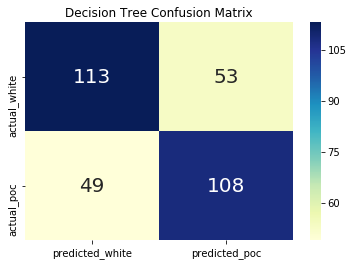

In [40]:
conf_matrix(y_val, y_pred_dec, 'Decision Tree')

#### ROC Curve

In [41]:
logit_roc = roc_curve_generator(X_val, y_val, 'Logistic Regression', logit)
rf_roc = roc_curve_generator(X_val, y_val, 'Random Forest', rf)
dec_roc = roc_curve_generator(X_val, y_val, 'Decision Tree', dec)

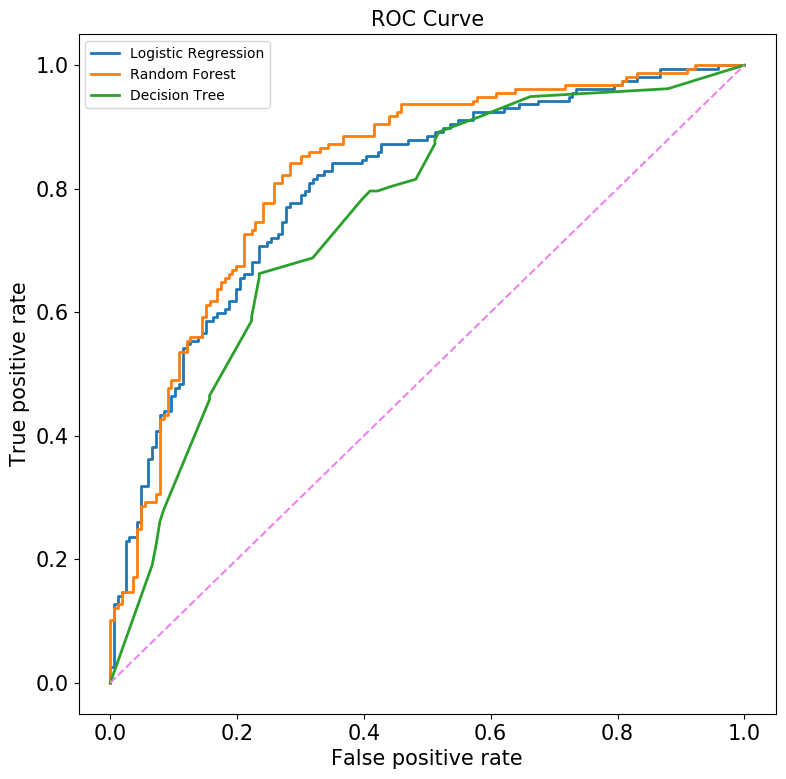

In [42]:
fig1 = plt.figure(figsize=[9,9], dpi=100)

plt.plot(logit_roc['Logistic Regression']['False Positive Rate'].values,    \
         logit_roc['Logistic Regression']['True Positive Rate'].values,    \
         lw=2, label='Logistic Regression')
plt.plot(rf_roc['Random Forest']['False Positive Rate'].values,    \
         rf_roc['Random Forest']['True Positive Rate'].values,    \
         lw=2, label='Random Forest')
plt.plot(dec_roc['Decision Tree']['False Positive Rate'].values,    \
         dec_roc['Decision Tree']['True Positive Rate'].values,    \
         lw=2, label='Decision Tree')

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ROC Curve', fontsize=15);
plt.legend(fontsize=10)

#### Precision-Recall Curve

In [43]:
# logit_prec_rec = prec_rec_curve_generator(X_test, y_test, 'Logistic Regression', logit)

## GridSearch

In [44]:
def gridsearch(X_train, y_train, X_test, y_test, model, model_name, params, cv, score, error_score):
    
    gs = GridSearchCV(model, params, cv=cv, scoring=score, error_score=error_score)
    gs.fit(X_train, y_train)
    y_true, y_pred = y_test, gs.predict(X_test)
    
    print(model_name)
    print('-------------------------------------')
    print('Best Parameters are:', gs.best_params_)
    print('accuracy =', accuracy_score(y_true, y_pred))
    print('precision = ', precision_score(y_true, y_pred))
    print('recall = ', recall_score(y_true, y_pred))
    print('f1 score = ', f1_score(y_true, y_pred))
    

In [45]:
logit_params = [
                {'max_iter': [1000000]},
#                 {'penalty': ['none', 'l2']},
                {'solver': ['liblinear']},
                {'C': [0.00001,0.0001,0.001,0.01,0.1,1]},
                {'random_state': [42]}
               ]

rf_params = [
             {'n_estimators': [10,100,1000]},
             {'max_depth': [2,6,10]},
             {'min_samples_leaf': [1,5,10]},
             {'max_leaf_nodes': [5,10]},
             {'random_state': [42]}
            ]



In [46]:
# gridsearch(X_tr, y_train, X_te, y_test, LogisticRegression(),
#            'Logistic Regression', logit_params, 5, 'f1', 0.0)

In [47]:
# gridsearch(X_tr, y_train, X_te, y_test, RandomForestClassifier(),
#            'Random Forest', rf_params, 5, 'f1', 0.0)

### Logistic Regression

In [48]:
for c in [0.00001,0.0001,0.001,0.01,0.1,1,10]:
    
    gs_logit = LogisticRegression(C=c, solver = 'liblinear', random_state=42, max_iter = 10000)
    gs_logit.fit(X_smote_train, y_smote_train)
    y_true, y_pred = y_val, gs_logit.predict(X_val)

    print('C = ', c)
    print('accuracy =', accuracy_score(y_true, y_pred))
    print('precision = ', precision_score(y_true, y_pred))
    print('recall = ', recall_score(y_true, y_pred))
    print('f1 score = ', f1_score(y_true, y_pred))
    print('--------------------------------------')

C =  1e-05
accuracy = 0.7275541795665634
precision =  0.7090909090909091
recall =  0.7452229299363057
f1 score =  0.7267080745341615
--------------------------------------
C =  0.0001
accuracy = 0.7368421052631579
precision =  0.7222222222222222
recall =  0.7452229299363057
f1 score =  0.7335423197492164
--------------------------------------
C =  0.001
accuracy = 0.739938080495356
precision =  0.7267080745341615
recall =  0.7452229299363057
f1 score =  0.7358490566037735
--------------------------------------
C =  0.01
accuracy = 0.7430340557275542
precision =  0.7341772151898734
recall =  0.7388535031847133
f1 score =  0.7365079365079364
--------------------------------------
C =  0.1
accuracy = 0.7430340557275542
precision =  0.73125
recall =  0.7452229299363057
f1 score =  0.7381703470031546
--------------------------------------
C =  1
accuracy = 0.739938080495356
precision =  0.7267080745341615
recall =  0.7452229299363057
f1 score =  0.7358490566037735
--------------------------

### Random Forest

In [49]:
for d in [4,5,6,7]:
    
    gs_rf = RandomForestClassifier(n_estimators = 200, max_depth=d, random_state=42)
    gs_rf.fit(X_smote_train, y_smote_train)
    y_true, y_pred = y_val, gs_rf.predict(X_val)

    print('Max Depth = ', d)
    print('N Estimators = ', 200)
    print('accuracy =', accuracy_score(y_true, y_pred))
    print('precision = ', precision_score(y_true, y_pred))
    print('recall = ', recall_score(y_true, y_pred))
    print('f1 score = ', f1_score(y_true, y_pred))
    print('--------------------------------------')

Max Depth =  4
N Estimators =  200
accuracy = 0.7554179566563467
precision =  0.7407407407407407
recall =  0.7643312101910829
f1 score =  0.7523510971786834
--------------------------------------
Max Depth =  5
N Estimators =  200
accuracy = 0.7708978328173375
precision =  0.7515151515151515
recall =  0.7898089171974523
f1 score =  0.7701863354037267
--------------------------------------
Max Depth =  6
N Estimators =  200
accuracy = 0.7616099071207431
precision =  0.7469135802469136
recall =  0.7707006369426752
f1 score =  0.7586206896551724
--------------------------------------
Max Depth =  7
N Estimators =  200
accuracy = 0.7647058823529411
precision =  0.7547169811320755
recall =  0.7643312101910829
f1 score =  0.759493670886076
--------------------------------------


## Final Models

**Logistic Regression performs the best, with an accuracy of 77.0% and F1 score of 75.6%**

### Logistic Regression

In [57]:
logit_final = LogisticRegression(C=0.01, solver = 'liblinear', random_state=42, max_iter = 10000)
X_smote_train_final, y_smote_train_final = SMOTE(random_state=42).fit_sample(X_train, y_train)
logit_final.fit(X_smote_train_final, y_smote_train_final)
y_true, y_pred = y_test, logit_final.predict(X_test)

In [58]:
from ipywidgets import interact
# Create a widget to show confusion matrix and the precision and recall scores given a sliding threshold value as an input
@interact(thresh=(0, 1, .01))
def logit_confusion(thresh):
    y_predict = (logit_final.predict_proba(X_test)[:, 1] > thresh)
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1_score = f1_score(y_test, y_predict)
    logit_confusion = confusion_matrix(y_test, y_predict)
    
    plt.figure(dpi=150)
    ax = sns.heatmap(logit_confusion, cmap=plt.cm.Purples, annot=True, square=True, fmt='g',
           xticklabels=['White', 'POC'],
           yticklabels=['White', 'POC'])
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Logistic Regression Confusion Matrix');
    
    return 'Threshold: ' + str(thresh), "Accuracy: {:6.4f},   Precision: {:6.4f},   Recall: {:6.4f},    F1-Score: {:6.4f}".format(accuracy, precision, recall, F1_score)

interactive(children=(FloatSlider(value=0.0, description='thresh', max=1.0, step=0.01), Output()), _dom_classe…

### Random Forest

In [59]:
rf_final = RandomForestClassifier(n_estimators = 200, max_depth=5, random_state=42)
X_smote_train_final, y_smote_train_final = SMOTE(random_state=42).fit_sample(X_train, y_train)
rf_final.fit(X_smote_train_final, y_smote_train_final)
y_true, y_pred = y_test, rf_final.predict(X_test)

In [60]:
from ipywidgets import interact
# Create a widget to show confusion matrix and the precision and recall scores given a sliding threshold value as an input
@interact(thresh=(0, 1, .01))
def logit_confusion(thresh):
    y_predict = (rf_final.predict_proba(X_test)[:, 1] > thresh)
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1_score = f1_score(y_test, y_predict)
    logit_confusion = confusion_matrix(y_test, y_predict)
    
    plt.figure(dpi=150)
    ax = sns.heatmap(logit_confusion, cmap=plt.cm.Purples, annot=True, square=True, fmt='g',
           xticklabels=['White', 'POC'],
           yticklabels=['White', 'POC'])
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Random Forest Confusion Matrix');
    
    return 'Threshold: ' + str(thresh), "Accuracy: {:6.4f},   Precision: {:6.4f},   Recall: {:6.4f},    F1-Score: {:6.4f}".format(accuracy, precision, recall, F1_score)

interactive(children=(FloatSlider(value=0.0, description='thresh', max=1.0, step=0.01), Output()), _dom_classe…

## Logistic Regression Coefficients

In [61]:
logit_coef = LogisticRegression(C=0.01, solver = 'liblinear', random_state=42, max_iter = 10000)
logit_coef.fit(X_smote_train, y_smote_train)
y_true, y_pred = y_val, logit_coef.predict(X_val)

In [62]:
import math

beta_list = []

for array in logit_final.coef_:
    for i in array:
        odds = math.exp(i)
        probs = odds/(1+odds)
        beta_list.append(odds)
        
beta_coeffs_dict = {'Feature Name': model_killings_df.columns, 'Coefficient Value': beta_list}
beta_coeffs_df = pd.DataFrame(beta_coeffs_dict)
beta_coeffs_df = beta_coeffs_df.sort_values(by='Coefficient Value', ascending=True).reset_index(drop=True)
beta_coeffs_df

Feature Name  Coefficient Value
0   signs_of_mental_illness           0.776160
1           month_May                 0.897406
2              region_South           0.907179
3                     armed           0.924072
4              threat_level           0.940181
5                      flee           0.949067
6                       age           0.955771
7           manner_of_death           0.957321
8                 city_type           0.957779
9           month_January             0.962821
10          month_December            0.970452
11          region_Mountain           0.975840
12          month_March               0.985537
13    share_native_american           0.992145
14             poverty_rate           0.992256
15             region_Other           0.993697
16          month_August              0.993862
17                     year           0.999136
18              day_of_week           1.000000
19            median_income           1.000000
20        region_West Coast           1.003492
21              share_white           1.004810
22          month_November            1.006908
23          month_July                1.006960
24          month_June                1.007118
25     percent_completed_hs           1.013310
26              body_camera           1.022412
27          month_September           1.022492
28          month_October             1.023366
29         region_Northeast           1.049401
30           share_hispanic           1.051153
31              share_asian           1.058842
32              share_black           1.064842
33          month_February            1.088870
34              top_30_city           1.094526
35                   gender           1.100269
36           region_Midwest           1.117212

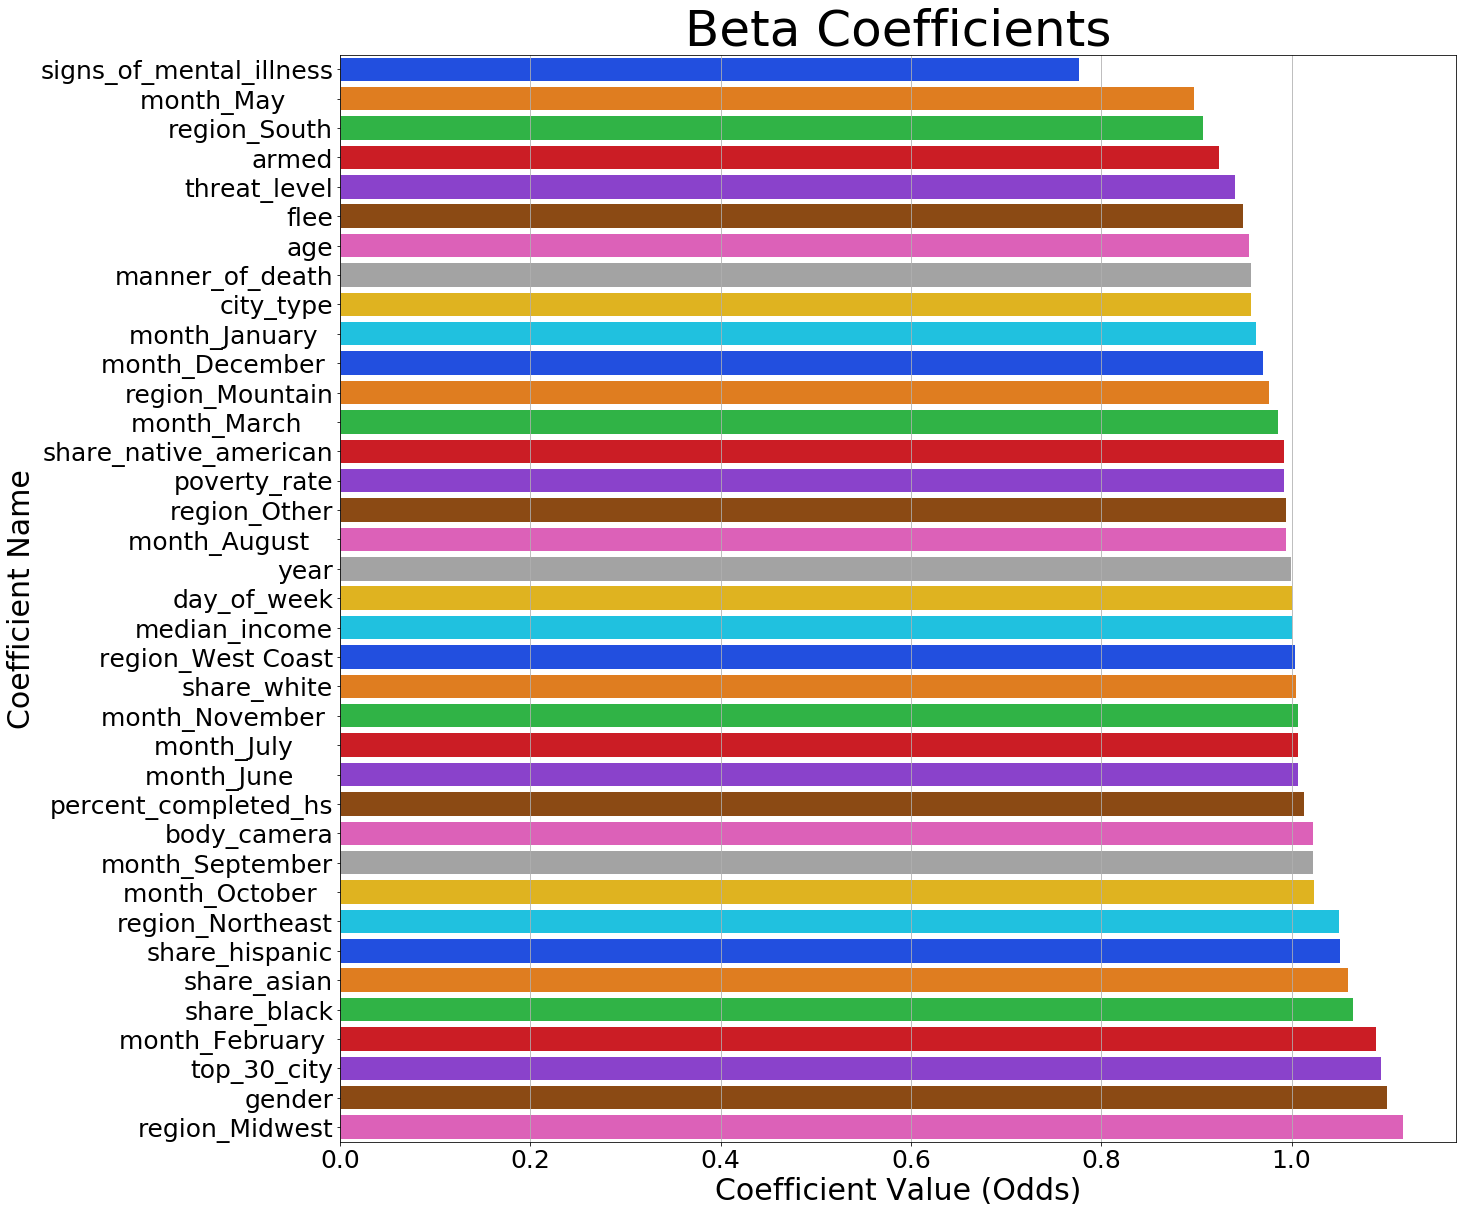

In [63]:
# Plot beta coefficients:

plt.figure(figsize=(20, 20))
plt.grid(axis='x', linestyle = '-')
sns.barplot(x = beta_coeffs_df['Coefficient Value'],y = beta_coeffs_df['Feature Name'], palette = "bright")
#             .set(xticklabels = ['-$10K', '-$5K', '$0', '$5K', '$10K', '$15K'], yticklabels = ['Concert in June', '# of Supporting Acts', 'Venue Capacity', 'Maximum Ticket Price', 'Minimum Ticket Price',  'Artist Genre: Indie Rock', 'Artist Genre: Electronic', 'Artist Genre: Pop', 'Artist Genre: Metal', 'Artist Genre: Jazz'])
plt.title('Beta Coefficients', fontsize = 50)
plt.xlabel('Coefficient Value (Odds)', fontsize = 30)
plt.ylabel('Coefficient Name', fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
# for i in beta_coeffs:
#     bars.text(i.name,i.tip, round(i.total_bill,2), color='black', ha="center")
plt.show()